In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
from IPython import display
from sklearn.utils.class_weight import compute_class_weight
import math

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [17]:
dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/speech"

train, val = keras.utils.audio_dataset_from_directory(directory=dir, batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')
label_names = np.array(train.class_names)
print()
print("label names:", label_names)

Found 137335 files belonging to 36 classes.
Using 109868 files for training.
Using 27467 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


Tensor("args_1:0", shape=(None,), dtype=int32)
Tensor("args_1:0", shape=(None,), dtype=int32)
(64, 16000)
(64,)


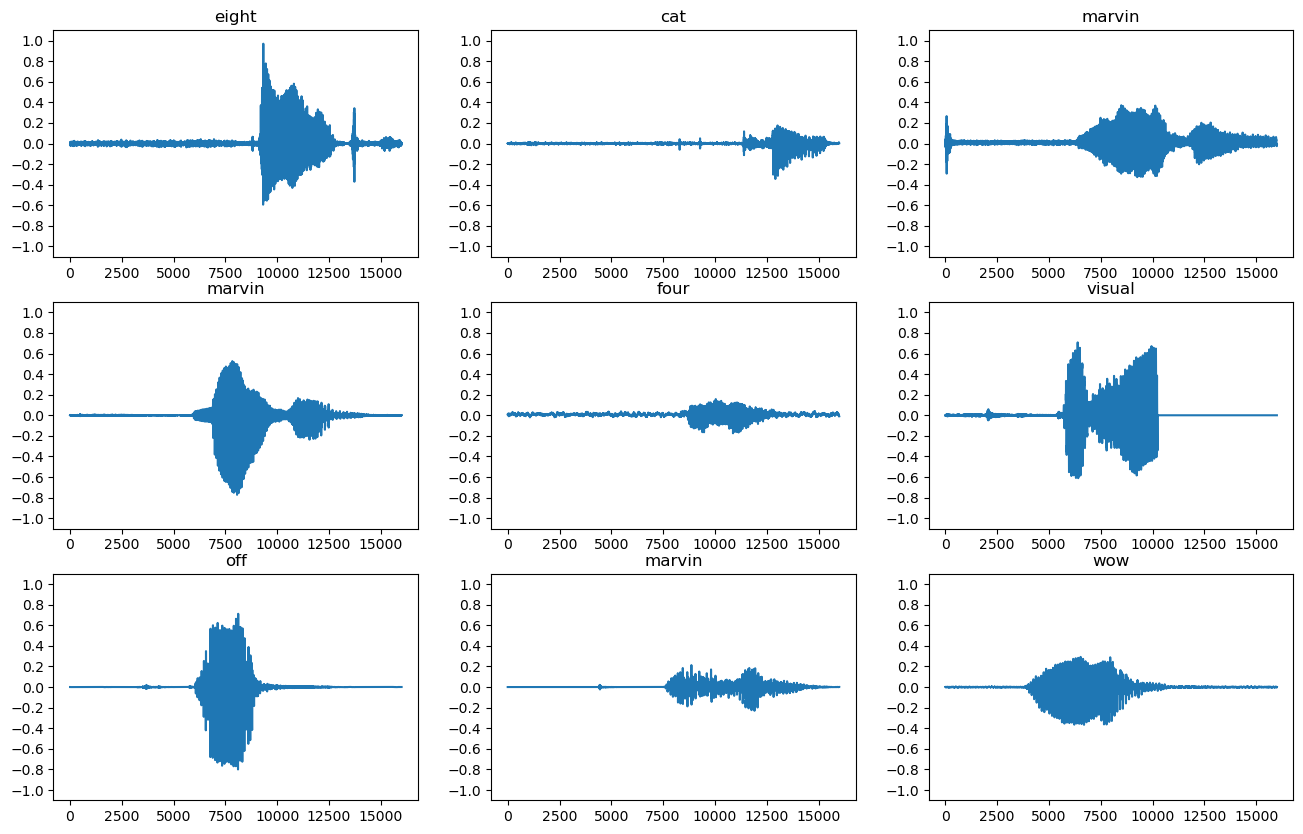

In [18]:
train.element_spec
# single channel audio
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  print(labels)
  return audio, labels

train = train.map(squeeze, tf.data.AUTOTUNE)
val = val.map(squeeze, tf.data.AUTOTUNE)

# make test dataset
test_ds = val.shard(num_shards=2, index=0)
val_ds = val.shard(num_shards=2, index=1)

for example_audio, example_labels in train.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


In [19]:
# convert to spectrogram


def spectrogram(wave):
    # Convert the waveform to a spectrogram via a Short-time fourier transform.
  s = tf.signal.stft(
      wave, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  s = tf.abs(s)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  s = s[..., tf.newaxis]
  return s

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  s = spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', s.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: eight
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: cat
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: marvin
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [20]:
def map_to_spectrogram(audio, label):
  s = spectrogram(audio)
  string = tf.gather(label_names, label)
  label = tf.where(string == "marvin", 1, 0)
  return s, label

def make_spec_ds(ds):
  return ds.map(
      #map_func=lambda audio,label: (spectrogram(audio), label),
      map_func=map_to_spectrogram,
      num_parallel_calls=tf.data.AUTOTUNE)


train_spectrogram = make_spec_ds(train)
val_spectrogram = make_spec_ds(val_ds)
test_spectrogram = make_spec_ds(test_ds)

class_counts = {}

# Iterate through the dataset and count occurrences of each class
for _, label in train_spectrogram:  # Assuming `train` is your dataset
    label_value = label.numpy() # Convert label to numpy
    for i in range(len(label_value)):
        if label_value[i] in class_counts:
            class_counts[label_value[i]] += 1
        else:
            class_counts[label_value[i]] = 1

print(class_counts)

total_samples = sum(class_counts.values())

# Number of classes
num_classes = len(class_counts)

print("Total samples:", total_samples)
print("Number of classes:", num_classes)

# Compute class weights
class_weights = {
    class_id: total_samples / (num_classes * count)
    for class_id, count in class_counts.items()
}
print("Class weights:", class_weights)


{1: 26863, 0: 83005}
Total samples: 109868
Number of classes: 2
Class weights: {1: 2.0449689163533487, 0: 0.6618155532799229}


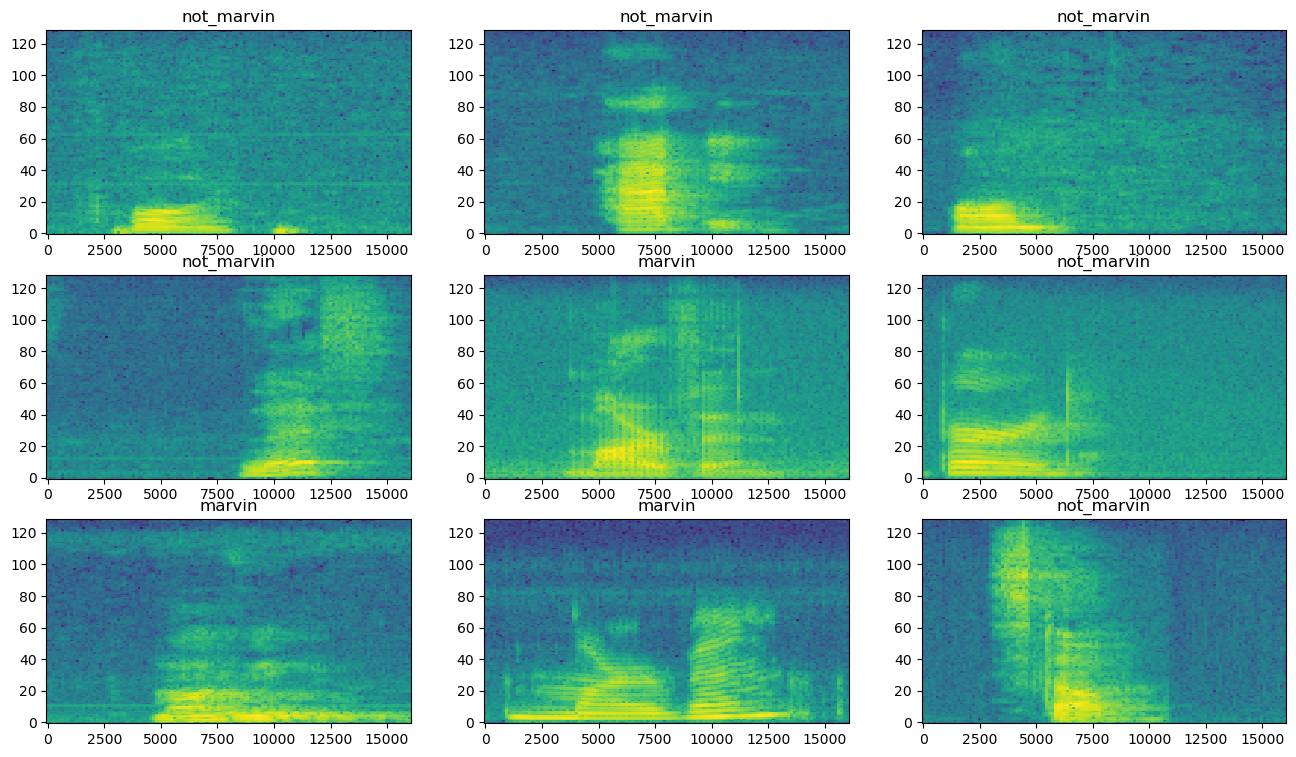

In [21]:



# train_spectrogram_ds = train_spectrogram.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# val_spectrogram_ds = val_spectrogram.cache().prefetch(tf.data.AUTOTUNE)
# test_spectrogram_ds = test_spectrogram.cache().prefetch(tf.data.AUTOTUNE)

train_spectrogram_ds = train_spectrogram
val_spectrogram_ds = val_spectrogram
test_spectrogram_ds = test_spectrogram


def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

binary_label_names=["not_marvin", "marvin"]

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(binary_label_names[example_spect_labels[i].numpy()])

plt.show()

In [158]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    # Downsample the input.
    keras.layers.Resizing(16, 16),
    # Normalize.
    #norm_layer,
    keras.layers.Normalization(),
    keras.layers.Conv2D(8, 2, activation='relu'),
    keras.layers.Conv2D(8, 2, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 16, 16, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 8)      │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │        15,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,068 (62.77 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 3 (16.00 B)

In [159]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()],
)

In [160]:
EPOCHS = 5
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    class_weight=class_weights,
)

Epoch 1/5
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - auc_4: 0.7886 - binary_accuracy: 0.7009 - loss: 0.5570 - precision_2: 0.4399 - recall_2: 0.7529 - val_auc_4: 0.9341 - val_binary_accuracy: 0.8562 - val_loss: 0.3309 - val_precision_2: 0.6547 - val_recall_2: 0.8727
Epoch 2/5
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - auc_4: 0.9067 - binary_accuracy: 0.8078 - loss: 0.3899 - precision_2: 0.5710 - recall_2: 0.8697 - val_auc_4: 0.9577 - val_binary_accuracy: 0.8774 - val_loss: 0.2717 - val_precision_2: 0.6887 - val_recall_2: 0.9106
Epoch 3/5
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - auc_4: 0.9326 - binary_accuracy: 0.8374 - loss: 0.3331 - precision_2: 0.6165 - recall_2: 0.8921 - val_auc_4: 0.9696 - val_binary_accuracy: 0.8890 - val_loss: 0.2388 - val_precision_2: 0.7086 - val_recall_2: 0.9285
Epoch 4/5
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - auc_4: 0.9442 - binary_accuracy: 0.8537 - loss: 0.3050 - precision_2: 0.6441 - recall_2: 0.9026 - val_auc_4: 0.9744 - val_binary_a

In [172]:
#my_dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/test/marvin/marvin1.wav"
my_dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/test/"

my_tests = keras.utils.audio_dataset_from_directory(directory=my_dir,
    output_sequence_length=16000,
    batch_size=32
    )

#.72937196

#0.7234743

my_tests = my_tests.map(squeeze, tf.data.AUTOTUNE)

# for x, y in my_tests.take(1):
#     print("label:", y.numpy())
#     for el in x:
#         display.display(display.Audio(el, rate=16000))


my_tests = make_spec_ds(my_tests)

model.save("marvin_model.keras")

model2 = keras.models.load_model("marvin_model.keras")


#model2.evaluate(my_tests)

y_prob = model.predict(my_tests, verbose=2)
print(y_prob)
res = np.round(y_prob)
print(res)

# x = tf.io.read_file(my_dir)
# x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
# x = tf.squeeze(x, axis=-1)
# waveform = x
# x = spectrogram(x)
# x = x[tf.newaxis,...]

# prediction = model(x)
# x_labels = ['no', 'marvin']
# prob = tf.nn.sigmoid(prediction[0])
# print(prob)
# plt.bar(x_labels, [1-prob[0], prob[0]])
# plt.title('No')
# plt.show()

# display.display(display.Audio(waveform, rate=16000))

Found 1 files belonging to 2 classes.


Tensor("args_1:0", shape=(None,), dtype=int32)
1/1 - 0s - 56ms/step
[[0.94516647]]
[[1.]]


In [ ]:


model.export(".")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


Saved artifact at '.'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='keras_tensor_44')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  6195264400: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  6195265360: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  6195263632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6195259216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6195263248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6195259984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6195259792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6195260752: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [41]:
converter2 = tf.lite.TFLiteConverter.from_saved_model(".")
converter2.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

def representative_dataset_gen():
    for input_value, _ in train_spectrogram.take(64):
        yield [input_value]
converter2.representative_dataset = representative_dataset_gen
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

DeadlineExceededError: saved_model.pb; Operation timed out

In [ ]:
!xxd -i converted_model.tflite > model_data.cc

python(9865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
